In [6]:
# Autor: Efe Şirin
# Date: 2024-03-11

# IMPORTS

import os
import random
import torch
import random
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from matplotlib import pyplot as plt
import datetime
from torchviz import make_dot
from torchsummary import summary

In [7]:
# ======================= PYTHON SETTINGS ======================= #
# =======================   GPU or CPU    ======================= #
device = torch.device("cpu")
# Check if GPU is available -> CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("There are %d GPU(s) available." % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))
# Apple Silicon GPU
elif torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    out = torch.ones(1, device=mps_device)
    print (out)
    print ("MPS device found. - Apple Silicon GPU")
else:
    print ("MPS device not found.")

# =======================   Ranom Seeds   ======================= #
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# =============================================================== #

tensor([1.], device='mps:0')
MPS device found. - Apple Silicon GPU


In [8]:

# Define data directories
data_dir = 'Dataset'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = torchvision.datasets.ImageFolder(root=f'{data_dir}/{train_dir}', transform=transform)

val_dataset = torchvision.datasets.ImageFolder(root=f'{data_dir}/{val_dir}', transform=transform)

test_dataset = torchvision.datasets.ImageFolder(root=f'{data_dir}/{test_dir}', transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print (f"Size of the training dataset: {len(train_dataset)}")

flag = True
# if False:
if flag:
    # ! testing with subset of the data
    # Define the portion of data you want to use
    portion = 0.002  # for example, use 50% of the data

    # Determine the size of the subset
    subset_size_train = int(len(train_dataset) * portion)
    subset_size_val = int(len(val_dataset) * portion)
    subset_size_test = int(len(test_dataset) * portion)

    # Create subsets of the datasets
    train_dataset_subset, _ = torch.utils.data.random_split(train_dataset, [subset_size_train, len(train_dataset) - subset_size_train])
    val_dataset_subset, _ = torch.utils.data.random_split(val_dataset, [subset_size_val, len(val_dataset) - subset_size_val])
    test_dataset_subset, _ = torch.utils.data.random_split(test_dataset, [subset_size_test, len(test_dataset) - subset_size_test])

    # print(f"Size of the training subset: {len(train_dataset_subset)}")

    # Create data loaders for the subsets
    train_loader = DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset_subset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset_subset, batch_size=batch_size, shuffle=False, pin_memory=True)



# Variables for information
trainin_samples_count = flag == True and len(train_dataset_subset) or len(train_dataset)
val_samples_count = flag == True and len(val_dataset_subset) or len(val_dataset)
test_samples_count = flag == True and len(test_dataset_subset) or len(test_dataset)

print(f"Size of the training dataset: {trainin_samples_count}")
print(f"Size of the validation dataset: {val_samples_count}")
print(f"Size of the test dataset: {test_samples_count}")



Size of the training dataset: 260
Size of the validation dataset: 16
Size of the test dataset: 31


In [9]:

# Define the CNN model
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: fake and real

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         MaxPool2d-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          18,496
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Linear-5                  [-1, 128]      33,554,560
            Linear-6                    [-1, 2]             258
Total params: 33,574,210
Trainable params: 33,574,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 30.00
Params size (MB): 128.08
Estimated Total Size (MB): 158.83
----------------------------------------------------------------


Training Progress: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it, Train Loss=0.795, Val Loss=0.752, Val Acc=0.625]


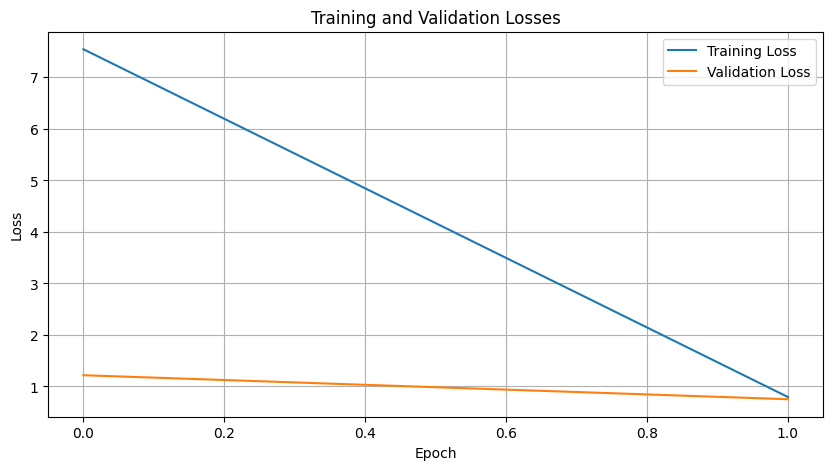

Model saved to model.pth


In [10]:
# ======================== GPU TRAINING ======================== #

# Initialize the model and move it to the GPU
model = CNNClassifier().to(device)


# Create a dummy input tensor
# dummy_input = torch.randn(1, 3, 256, 256)  # Batch size 1, 3 channels, 256x256 image size

# # Generate the visualization
# output = model(dummy_input)
# graph = make_dot(output, params=dict(model.named_parameters()))
# graph.render("CNN_Model_Visualization_256x256", format="png", cleanup=True)

# Create a dummy input tensor
# dummy_input = torch.randn(1, 3, 256, 256)  # Batch size 1, 3 channels, 256x256 image size

# Print the model summary
# summary(model, input_size=(3, 256, 256), device='cpu')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define training function with early stopping and loss tracking
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, patience=3):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    current_patience = 0

    # Initialize tqdm progress bar
    progress_bar = tqdm(total=num_epochs, desc="Training Progress", position=0)
    
    # for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        accuracy = correct / total

        progress_bar.update(1)
        progress_bar.set_postfix({'Train Loss': epoch_loss, 'Val Loss': val_loss, 'Val Acc': accuracy})
        
        # tqdm.write(
        #     f"Epoch {epoch+1}/{num_epochs}, "
        #     f"Train Loss: {epoch_loss:.4f}, "
        #     f"Validation Loss: {val_loss:.4f}, "
        #     f"Validation Accuracy: {accuracy:.4f}"
        # )
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            current_patience = 0
        else:
            current_patience += 1
            if current_patience >= patience:
                print("Early stopping triggered.")
                break
    
    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=2)


# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)


# Get the current time
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Create directory if it doesn't exist
save_dir = os.path.join("out", current_time)
os.makedirs(save_dir, exist_ok=True)

# Save the plot
plt.savefig(os.path.join(save_dir, "losses.png"))

# Evaluate the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total

plt.show()

# Save the training, validation losses, and test accuracy to details.txt
with open(os.path.join(save_dir, "details.txt"), "w") as file:
    file.write(" === Training Details ===\n\n")
    file.write(" Simple CNN Classifier\n")
    file.write("Training Losses:\n")
    file.write(str(train_losses) + "\n\n")
    file.write("Validation Losses:\n")
    file.write(str(val_losses) + "\n\n")
    file.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    # Write the number of training samples
    file.write(f"Number of training samples: {trainin_samples_count}\n")
    file.write(f"Number of validation samples: {val_samples_count}\n")
    file.write(f"Number of test samples: {test_samples_count}\n")

# Save the model
model_save_path = os.path.join(save_dir, "model.pth")
torch.save(model.state_dict(), model_save_path)
print("Model saved to model.pth")

In [11]:
# # ========================  CNN CLASSIFIER  ======================== #
# # Initialize the model
# model = CNNClassifier()

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Define training function
# def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * inputs.size(0)
#         epoch_loss = running_loss / len(train_loader.dataset)
        
#         # Validation
#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 outputs = model(inputs)
#                 _, predicted = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)
#         val_loss /= len(val_loader.dataset)
#         accuracy = correct / total
        
#         print(f"Epoch {epoch+1}/{num_epochs}, "
#               f"Train Loss: {epoch_loss:.4f}, "
#               f"Validation Loss: {val_loss:.4f}, "
#               f"Validation Accuracy: {accuracy:.4f}")

# # Train the model
# train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1)

In [12]:

# # Evaluate the model
# model.eval()
# test_correct = 0
# test_total = 0
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         test_total += labels.size(0)
#         test_correct += (predicted == labels).sum().item()


# print(f"Test Accuracy: {test_correct / test_total:.4f}")

# # Save the model
# torch.save(model.state_dict(), 'model.pth')
# print("Model saved to model.pth")


In [13]:
# ========================  TRANSFER LEARNING  ======================== #

# Define the CNN model
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: fake and real

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define training function with transfer learning
def train_model_with_transfer_learning(backbone, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        backbone.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = backbone(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation
        backbone.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = backbone(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        accuracy = correct / total
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {accuracy:.4f}")

# Load a pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Freeze all the parameters in the pre-trained model
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the number of classes in your problem
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)  # 2 classes: fake and real

# Create an instance of the transfer learning model with ResNet-18 backbone
transfer_model = resnet18.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

# Define data loaders (Assuming train_loader and val_loader are already defined)

# Train the model with transfer learning
train_model_with_transfer_learning(transfer_model, criterion, optimizer, train_loader, val_loader, num_epochs=1)



In [14]:

# # Evaluate the model
# transfer_model.eval()
# test_correct = 0
# test_total = 0
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = transfer_model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         test_total += labels.size(0)
#         test_correct += (predicted == labels).sum().item()

# print(f"Test Accuracy: {test_correct / test_total:.4f}")

# # Save the model
# torch.save(transfer_model.state_dict(), 'transfer_model.pth')